#### Student Name:
#### Student ID:

# Overview
### Due Jan 25th

### GAN, chroma (MIDI) and pix2pix

Instructions:

* This notebook is an interactive assignment; please read and follow the instructions in each cell.

* Cells that require your input (in the form of code or written response) will have 'Question #' above.

* After completing the assignment, please submit this notebook and printout as a PDF.


In [ ]:
# If you're collaboraing with a classmate, please fill in the following:

collaboration = {
    "PLACE YOUR STUDENT ID HERE" : "PLACE YOUR COLLABORATOR'S STUDENT ID HERE"
}

In this notebook we explore a style transfer application that tries to change the musical texture of a piece while maintaining the harmonic structure. In order to do so we train a pix2pix type of model that learns the relations between chroma and the musical texture (distribution of notes). For this purpose we extract chroma from MIDI data and learn a generator that complements the notes from a given texture. You can think about this as something similar to pix2pix that learns completion of image textures from a sketch. In the image GAN the contours for training are generated using an edge detection on a complete image. You can read more about the history of Midi formats at https://cecm.indiana.edu/361/midi.html#:~:text=MIDI%20is%20an%20acronym%20that,each%20other%2C%20using%20MIDI%20messages.

# 1. Imports and Loading Data
Before running, please download the files from https://drive.google.com/drive/folders/1B3WpC9hRH4W6yzh7gahFAZodw1lP4aaM?usp=share_link make sure to upload the following to your python directory
- reverse_pianoroll.py
- convert.py
- Classical_Music_Midi.zip and unzip it

In [2]:
# !unzip content/Classical_Music_Midi.zip -d content/Classical_Music_Midi/
!pip install down
!gdown --folder https://drive.google.com/drive/folders/1B3WpC9hRH4W6yzh7gahFAZodw1lP4aaM --output ./content

Archive:  content/Classical_Music_Midi.zip
  inflating: content/Classical_Music_Midi/albeniz/alb_esp1.mid  
  inflating: content/Classical_Music_Midi/albeniz/alb_esp2.mid  
  inflating: content/Classical_Music_Midi/albeniz/alb_esp3.mid  
  inflating: content/Classical_Music_Midi/albeniz/alb_esp4.mid  
  inflating: content/Classical_Music_Midi/albeniz/alb_esp5.mid  
  inflating: content/Classical_Music_Midi/albeniz/alb_esp6.mid  
  inflating: content/Classical_Music_Midi/albeniz/alb_se1.mid  
  inflating: content/Classical_Music_Midi/albeniz/alb_se2.mid  
  inflating: content/Classical_Music_Midi/albeniz/alb_se3.mid  
  inflating: content/Classical_Music_Midi/albeniz/alb_se4.mid  
  inflating: content/Classical_Music_Midi/albeniz/alb_se5.mid  
  inflating: content/Classical_Music_Midi/albeniz/alb_se6.mid  
  inflating: content/Classical_Music_Midi/albeniz/alb_se7.mid  
  inflating: content/Classical_Music_Midi/albeniz/alb_se8.mid  
  inflating: content/Classical_Music_Midi/bach/bach_846

In [3]:
# !brew install -y fluidsynth

Password:
sudo: a password is required


In [4]:
# !pip install --upgrade pyfluidsynth

In [7]:
# !pip install pretty_midi


ERROR: Could not find a version that satisfies the requirement reverse_pianoroll (from versions: none)
ERROR: No matching distribution found for reverse_pianoroll


In [31]:
import pretty_midi
from  content import reverse_pianoroll
from content import convert
import librosa

In [32]:
import numpy as np
import sys
import random

In [33]:
#all necessary imports: use pip install [library name] to add to environment

import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from os import listdir
import glob

In [34]:
#add songs to data
def get_songs(path):
    files = glob.glob('{}/*.mid*'.format(path))
    songs = {}
    for f in files:
        try:
            data = pretty_midi.PrettyMIDI(f)
            song = data.get_piano_roll(fs=16)
            song = convert.forward(song)
            # song = np.transpose(song) #if your code matrices aren't working, try uncommenting this. the convert.py file might not be updated
            songs[f] = {
                'original_midi': data,
                'song': song
            }
        except Exception as e:
            raise e
    return songs

In [36]:
from IPython import display
import fluidsynth

_SAMPLING_RATE = 16000
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [65]:
#custom function to extract chroma features from song
def add_chromas(songs):
    """
    the add_chromas function takes in a dictionary of songs and adds a chroma feature to each song in the dictionary.
    for each song in the songs (which is the piano roll of the song), extract the chroma features by finding the notes that are 
    played at each time step. 
    by checking if the value of the note is greater than 0. if so we find the note using mod 12 and increment the corresponding 
    index in the chroma vector.
    """
    chromas = []
    for song in songs:
        chroma = np.zeros(shape=(np.shape(songs[song]['song'])[0], 12))
        for i in np.arange(np.shape(songs[song]['song'])[0]): # for each time step
            for j in np.arange(78): # the shape of songs[song]['song'][i] is 156 (78*2)   
                if songs[song]['song'][i][j] > 0:
                    chroma[i][np.mod(j,12)] += 1 # there are 12 notes in an octave so we can just mod by 12 to get the correct chord index
        songs[song]['chroma'] = chroma

    return songs

songs = get_songs('./content/Classical_Music_Midi/mozart')
songs = add_chromas(songs)
print ("{} songs processed".format(len(['song' in songs[f] for f in songs])))
print ("{} chromas processed".format(len(['chroma' in songs[f] for f in songs])))

AssertionError: 

#### Exploring the song and chroma representations

Looking at a random song segment

In [39]:
cur_song = list(songs.keys())[0]
song = songs[cur_song]['song']
chroma = songs[cur_song]['chroma']
np.shape(song), np.shape(chroma)

((3809, 156), (3809, 12))

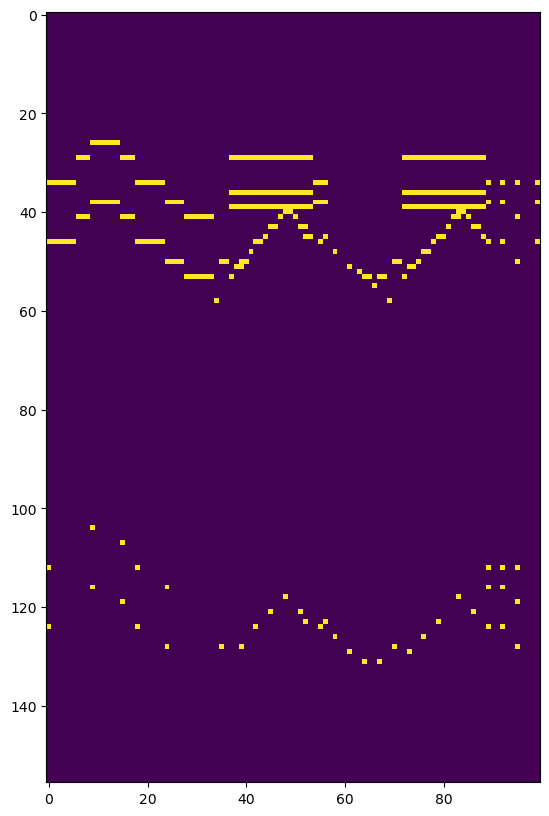

In [40]:
plt.figure(figsize = (20,10))
plt.imshow(100*song[:100,:].T)

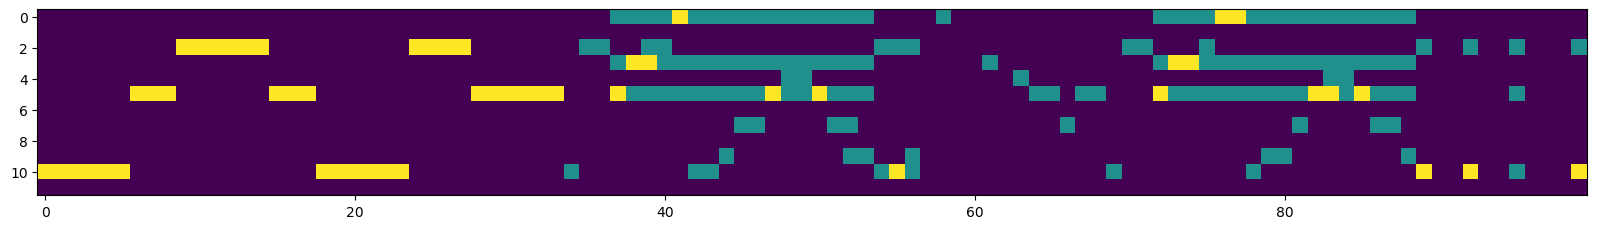

In [41]:
plt.figure(figsize = (20,10))
plt.imshow(100*chroma[:100,:].T)

##### Question 1 [5 points]
Describe what the chromas function does. In your answer refer to musical terms of note names and octave numbers. How does that resemble or differ from the chroma feature that is computed for audio spectrum? Use the figures to demonstrate the explanation.

Hint: Refresh the musical terms by looking at the lecture slides and consider what type of music anaylsis the audio chroma is used for. If you are interested more in musical theory you may also consider the concepts of "pitch class" and "music set theory" that are explained in https://en.wikipedia.org/wiki/Musical_note and https://en.wikipedia.org/wiki/Set_theory_%28music%29

the add_chromas function takes in a dictionary of songs and adds a chroma feature to each song in the dictionary.
for each song in the songs (which is the piano roll of the song), extract the chroma features by finding the notes that are played at each time step 
by checking if the value of each of the 78 piano roll notes is greater than 0 - active. if so we find the musical (c,d,e,f...) note using mod 12 and increment the corresponding index in the chroma feature - chord.

# 2. Setting Up GAN Model

In [51]:
lowest_note = 0 #the index of the lowest note on the piano roll
highest_note = 78 #the index of the highest note on the piano roll
note_range = highest_note-lowest_note #the note range

num_timesteps  = 4 #This is the number of timesteps that we will create at a time
X_dim = 2*note_range*num_timesteps #This is the size of the visible layer.
Z_dim = 12*num_timesteps 
n_hidden = 50 #This is the size of the hidden layer

print(X_dim,Z_dim)

624 48


##### Question 2 [5 points]

Explain what aspects of music (pitch, rhythm, note duration) are captured by the latent random Z? In your answer refer to the representaiton of the song data. Note how song matrix differs from standard pianoroll.

random latent Z represent the 12 chromas * timesteps.
chroma is a note class (all the do, all the re,...)

Z is the harmonic structure 


In [49]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [52]:
tf.disable_v2_behavior()

#setting up model, discriminator weights and biases
X = tf.placeholder(tf.float32, shape=[None, X_dim])


D_W1 = tf.Variable(xavier_init([X_dim+Z_dim, 512]))
D_b1 = tf.Variable(tf.zeros(shape=[512]))

D_W2 = tf.Variable(xavier_init([512, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]

In [53]:
#setting up model, generator weights and biases

#z is the space we're generating from
Z = tf.placeholder(tf.float32, shape=[None, Z_dim])

G_W1 = tf.Variable(xavier_init([Z_dim, 128]))
G_b1 = tf.Variable(tf.zeros(shape=[128]))

G_W2 = tf.Variable(xavier_init([128, X_dim]))
G_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

theta_G = [G_W1, G_W2, G_b1, G_b2]

In [54]:
def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob

In [55]:
def discriminator(x,c):

    D_h1 = tf.nn.relu(tf.matmul(tf.concat([x,c],1), D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit

In [56]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')

        plt.imshow(sample.reshape(78, 30), cmap='Greys_r')


    return fig

In [62]:
G_sample = generator(Z)

In [58]:
D_real, D_logit_real = discriminator(X,Z)

In [59]:
D_fake, D_logit_fake = discriminator(G_sample,Z)

##### Question 3 [10 points]
In standard GAN, the discriminator receives as input true or fake (generated) data only. Explain why in our case the disrciminator receives as input both the data and an additional variable Z? How this Z differs from the usual GAN input of a random vector?

This is different from a standard GAN discriminator because it's conditional - it doesn't just try to determine if the input is real or fake, but also checks if it matches the given chroma features. This helps ensure the generated music maintains the harmonic structure specified by the chroma input.
The discriminator is essentially learning to identify not just realistic music, but realistic music that properly corresponds to the given chroma features.

In [66]:

# Alternative losses:
# -------------------
Lambda = 100
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))
G_loss_L1 = tf.reduce_mean(tf.losses.mean_squared_error(X,G_sample))
G_loss = G_loss_fake + Lambda*G_loss_L1

##### Question 4 [10 points]
Explain the two components of the discriminator loss in the D_loss expression. Why the real loss uses tf.ones_like andthe fake loss uses tf.zeros_like in the cross entory loss? What are the statistical distributions (which datasets are used) in computational of the real and fake losses. In your answers you may either include an equation image or write the loss equaiton in latex mathamtical notation inside Markdown cell.

### Discriminator Loss Components

D_loss_real - its the real data componenet and we use one_like because we want to maximize the probability of correctly identifying real samples (output close to 1)
D_loss_fake - This component handles generated/fake samples. and we use zero_like because we want to minimize the probability of being fooled by generated samples (output close to 0) 

##### Question 5 [10 points]
In the generator loss G_loss we add an L1 loss. What does it represent? Why do you think we might want to add the L1 loss to the GAN model? We will explore this question further down the assignment, so at this point write down your best explanation based on the equations themselves without running any experiments.

``` your response here ```

In [ ]:
#optimizing functions
D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

In [ ]:
#output midi file folder
if not os.path.exists('out/'):
    os.makedirs('out/')

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# 3. Training GAN Model

In [ ]:
i = 0
num_epochs = 200000
batch_size = 100
S_cutoff = 0.5
#commented out print statements output different losses, and plotting functions plot the piano roll and chroma.
while i <= num_epochs:
    # for song, chroma in zip(songs, chromas):
    for files in songs:
        song = songs[files]['song']
        chroma = songs[files]['chroma']
        # The songs are stored in a time x notes format. The size of each song is timesteps_in_song x 2*note_range
        # Here we reshape the songs so that each training example is a vector with num_timesteps x 2*note_range elements
        song = np.array(song)
        song_steps = np.floor(song.shape[0]/num_timesteps).astype(int)
        song = song[:song_steps*num_timesteps]
        song = np.reshape(song, [song_steps, song.shape[1]*num_timesteps])
        chroma = np.array(chroma)
        chroma = chroma[:song_steps*num_timesteps]
        chroma = np.reshape(chroma, [song_steps, chroma.shape[1]*num_timesteps])
        batch_size = min(batch_size,len(song))
        # Train the RBM on batch_size examples at a time
        for ind in range(0, len(song), batch_size):
            X_mb = song[ind:ind+batch_size]
            ch = chroma[ind:ind+batch_size]
            _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: ch})
            _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={X: X_mb, Z: ch})

            if i % 1000 == 0:
                print('Iter: {}'.format(i))
                dloss = ('D_Loss: {:.4}'. format(D_loss_curr))
                gloss = ('G_Loss: {:.4}'. format(G_loss_curr))
                print(dloss)
                print(gloss)

                samples = sess.run(G_sample, feed_dict={Z: ch})

                S = np.reshape(samples, (ch.shape[0]*num_timesteps, 2*note_range))
                thresh_S = S>=S_cutoff

                thresh_S = np.transpose(thresh_S)


                C = np.reshape(ch, (ch.shape[0]*num_timesteps, 12))

                test = reverse_pianoroll.piano_roll_to_pretty_midi(convert.back(thresh_S), fs=16)
                test.write('out/{}.mid'.format(i))

            i += 1

# 4. Style Transfer with a New Genre Dataset

In this part we will explore using the trained GAN to compose new music according to the harmonic structure of another musical input. In a way this comprises of a style transfer between the input music that belongs to style A and the output music that is generated using GAN trained on style B. In the example we will used J.S.Bach as our input (Style A) and output music in Mozart's style that was use to train our GAN (Style B). The new Mozart piece should follow the harmonic structure (chord progressions) of the Bach input.

In [ ]:
#for testing, we will be using a different composer dataset to input into the generator here.
test_song = get_songs("./Classical_Music_Midi/bach")
test_song = add_chromas(test_song)

print ("{} songs processed".format(len(['song' in test_song[f] for f in test_song])))
print ("{} chromas processed".format(len(['chroma' in test_song[f] for f in test_song])))

3 songs processed
3 songs processed


In [ ]:
#converted midi file folder
if not os.path.exists('converted/'):
    os.makedirs('converted/')

In [ ]:
i = 0
S_cutoff = 0.5

# for i,c in enumerate(test_chromaz):
for song in test_song:
    test_chroma = np.array(test_song[song]['chroma'])

    test_chroma = test_chroma[:np.floor(test_chroma.shape[0]/num_timesteps).astype(int)*num_timesteps]
    test_chroma = np.reshape(test_chroma, [int(test_chroma.shape[0]/num_timesteps), test_chroma.shape[1]*num_timesteps])

    out_samples = sess.run(G_sample, feed_dict={Z: test_chroma})

    S = np.reshape(out_samples, (np.floor(out_samples.shape[0]*out_samples.shape[1]/2/note_range).astype(int), 2*note_range))
    C = np.reshape(test_chroma, (test_chroma.shape[0]*num_timesteps, 12))

    thresh_S = S>=S_cutoff
    thresh_S = np.transpose(thresh_S)

    test = reverse_pianoroll.piano_roll_to_pretty_midi(convert.back(thresh_S), fs=16)
    test_song[song]['generated'] = test
    test.write('converted/{}.mid'.format(song.split('/')[-1].split('.')[0]+"generated"))



##### Question 6 [10 points]
Open the conversion results in a musical MIDI software (such as Musescore) and observe/listen to the results. Write down your impressions about the quality of the musical texture style transfer - did the harmonic structure follow the Bach input? How did the notes distribution (choice of pitches and durations) change relative to the original Bach piece? Does the S_cutoff parameter affect the outcome, and if so, how?

Summarize your findings and suggest some conclusions. Can you point to any musical aspects that were poorly modeled and ideas of improvement?

``` your response here ```

# 5. Further experiments

##### Question 7 & 8: [total 30 points]

Choose two of the experiments and report their results:

1. Explore style transfer between more distant styles: For this purpose you may use the Pop_Music_Midi dataset and repeat the Style Transfer Experiment between Classical and Pop music (and vice versa). Report your findings in qualitative ways and submit the midi results together with your explanation. [20 Points]

2. Expermment with L1 distance: retrain the GAN model with very small and very large Lambda. What are the effects of such changes? When is the texture of the output more or less musical? Are the harmonic progressions of the input followed or ignored? Any other observations? [20 Points]

3. Create your own song: use the leadsheet2chroma.py file provided to create a Mozart style composition from your own leadsheet input. Provide the leadsheet in text format and the midi file results. Report your observations about the musical quality of the results. You may alter the leadsheet2chroma.py to fit other chords if you wish, or train GAN in a style different then Mozart. [20 Points]



``` your response here ```

##### Question 9 [20 points]

Please record a 2-5 minute video of yourself explaining questions 1 to 7.

If you are shy (or have a bad hairday) you can use filters to augment or cover your face. Please submit it as a public google drive url.

``` your response here ```